In [1]:
from functools import partial
import os

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
#import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
#from keras import backend, optimizers

In [3]:
# force channels-first ordering for all loaded images
#backend.set_image_data_format('channels_last')  #The models are designed to use channels first

image_directory = "/kaggle/input/569-images-masks-water/Val/Images/"
mask_directory = "/kaggle/input/569-images-masks-water/Val/Masks/"

In [4]:
SIZE = 128
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


In [5]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jpg'):
#         Print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [6]:
#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [7]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

In [9]:
X_train.shape

(455, 128, 128, 3)

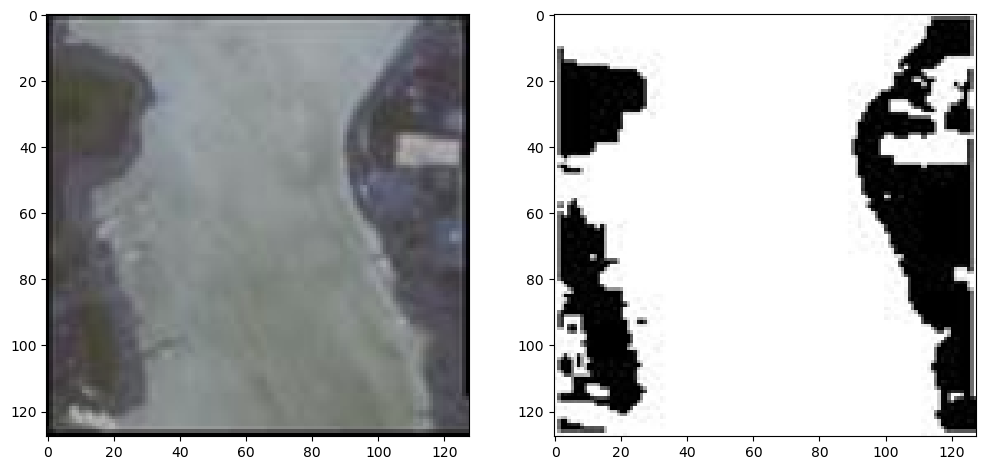

In [10]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

In [11]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8
#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
#from focal_loss import BinaryFocalLoss

In [12]:
!pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.1 MB/s eta 0:00:00


In [13]:
from keras_unet_collection import models, losses

In [14]:
#Model 1: Unet with ImageNet trained VGG16 backbone
help(models.att_unet_2d)

Help on function att_unet_2d in module keras_unet_collection._model_att_unet_2d:

att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet')
    Attention U-net with an optional ImageNet backbone
    
    att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='att-unet')
                
    ----------
    Oktay, O., Schlemper, J., Folgoc, L.L., Lee, M., Heinrich, M., Misawa, K., Mori, K., McDonagh, S., Hammerla, N.Y., Kainz, B. 
    and Glocker, B., 2018. Attention u-

In [15]:
model_att_unet = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           atten_activation='ReLU', attention='add', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

/opt/conda/lib/python3.10/site-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 [==============================] - 0s 0us/step


In [16]:
model_att_unet.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-3), 
              metrics=['accuracy', losses.dice_coef])

In [17]:
print(model_att_unet.summary())

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                   

In [18]:
start1 = datetime.now() 
att_unet_history = model_att_unet.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=30)
stop1 = datetime.now()

Epoch 1/30
57/57 [==============================] - 43s 285ms/step - loss: 0.4080 - accuracy: 0.6884 - dice_coef: 0.6048 - val_loss: 2.6507 - val_accuracy: 0.2303 - val_dice_coef: 0.4714
Epoch 2/30
57/57 [==============================] - 8s 142ms/step - loss: 0.3266 - accuracy: 0.7245 - dice_coef: 0.6731 - val_loss: 0.8560 - val_accuracy: 0.5959 - val_dice_coef: 0.6229
Epoch 3/30
57/57 [==============================] - 8s 133ms/step - loss: 0.3017 - accuracy: 0.7332 - dice_coef: 0.7003 - val_loss: 1.2432 - val_accuracy: 0.5500 - val_dice_coef: 0.6023
Epoch 4/30
57/57 [==============================] - 8s 144ms/step - loss: 0.2844 - accuracy: 0.7393 - dice_coef: 0.7167 - val_loss: 0.3308 - val_accuracy: 0.7245 - val_dice_coef: 0.7498
Epoch 5/30
57/57 [==============================] - 8s 145ms/step - loss: 0.2702 - accuracy: 0.7448 - dice_coef: 0.7303 - val_loss: 0.2972 - val_accuracy: 0.7398 - val_dice_coef: 0.7759
Epoch 6/30
57/57 [==============================] - 8s 145ms/step - l

In [21]:
#Execution time of the model 
execution_time_att_unet = stop1-start1
print("att_unet execution time is: ", execution_time_att_unet)

att_unet execution time is:  0:05:27.258567


In [22]:
model_att_unet.save('water_bodies_segmentation_keras_att_unet_collection.hdf5')

In [23]:
# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd    
att_unet_history_df = pd.DataFrame(att_unet_history.history) 

with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

In [24]:
#Check history plots, one model at a time
history = att_unet_history

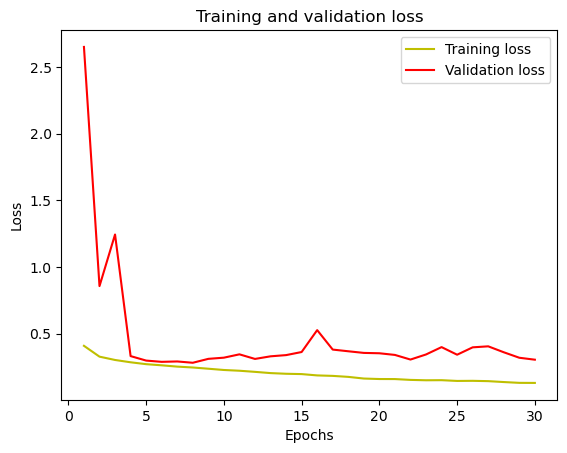

In [25]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

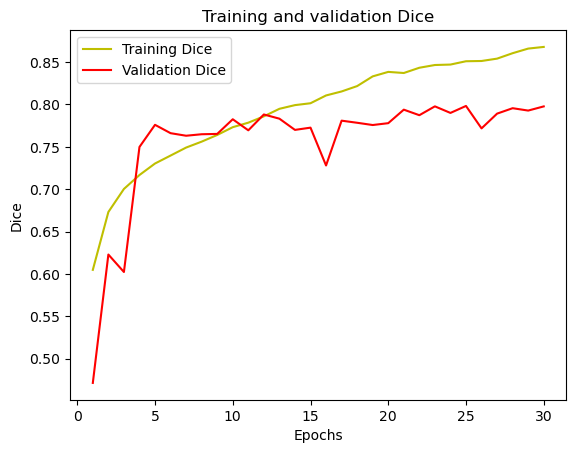

In [26]:
acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()


In [27]:
model = model_att_unet

In [59]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119


In [60]:
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 22ms/step


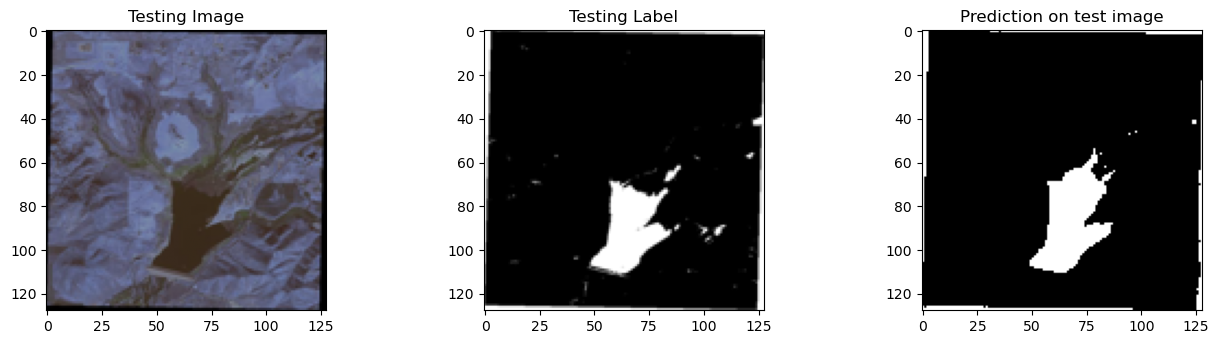

In [61]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [31]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())



Mean IoU = 0.73753583


In [32]:
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    #print(IoU)
    

1/1 [==============================] - 0s 21ms/step


In [33]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    


Mean IoU is:  [0.71291685]


In [34]:
TEST_directory= "/kaggle/input/rgb-images-test/"

In [35]:
SIZE = 128
TEST_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

In [36]:
TEST = os.listdir(TEST_directory)
for i, image_name in enumerate(TEST):
    if (image_name.split('.')[1] == 'jpg'):
        print(TEST_directory+image_name)
        image = cv2.imread(TEST_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        TEST_dataset.append(np.array(image))

/kaggle/input/rgb-images-test/R094_LOKOS_B02_B03_B04_B08_10m_1.jpg
/kaggle/input/rgb-images-test/R051_Taourirt_B02_B03_B04_B08_2.jpg
/kaggle/input/rgb-images-test/R051_Taourirt_B02_B03_B04_B08_3.jpg
/kaggle/input/rgb-images-test/R051_Taourirt_B02_B03_B04_B08_1.jpg
/kaggle/input/rgb-images-test/R051_Taourirt_B02_B03_B04_B08_5.jpg
/kaggle/input/rgb-images-test/R094_LOKOS_B02_B03_B04_B08_10m_3.jpg
/kaggle/input/rgb-images-test/R094_LOKOS_B02_B03_B04_B08_10m_0.jpg
/kaggle/input/rgb-images-test/R094_OUARGHA_B02_B03_B04_B08_10m_0.jpg
/kaggle/input/rgb-images-test/R094_OUARGHA_B02_B03_B04_B08_10m_2.jpg
/kaggle/input/rgb-images-test/R094_OUARGHA_B02_B03_B04_B08_10m_1.jpg
/kaggle/input/rgb-images-test/R094_LOKOS_B02_B03_B04_B08_10m_2.jpg


In [37]:
#Normalize images
TEST_dataset = np.array(TEST_dataset)/255.

In [56]:
import random
TEST_img_number = random.randint(0, TEST_dataset.shape[0]-1)  #Test with 119

In [57]:
TEST_img = TEST_dataset[TEST_img_number]
TEST_img_input=np.expand_dims(TEST_img, 0)
prediction = (model.predict(TEST_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 21ms/step


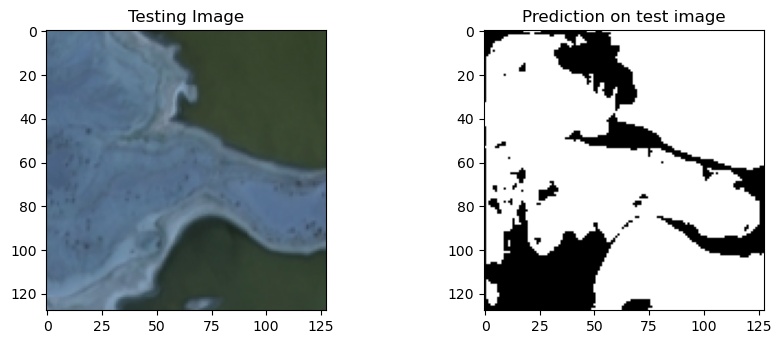

In [58]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(TEST_img, cmap='gray')
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()